In [11]:

from importlib import reload
import pandas as pd
import h5py
import numpy as np
import os

import utilities

reload(utilities)

<module 'utilities' from '/home/karim/magistere/Stage/github/Earthquakes/New_code/Code to clean/utilities.py'>

# Functions to build displacement maps and labels for each main shock in input HDF5 file

In [2]:
## Global variables:
n_seq_init = 0  # Number of sequences processed
n_seq_discarded = 0  # Number of sequences discarded


def process_main_shock_data(hdf5_file_path, output_path):
    """Process main shocks data to generate interpolated displacement maps."""
    with h5py.File(hdf5_file_path, 'r') as file:
        for id_seq in file.keys():
            process_single_main_shock(file[id_seq], output_path, id_seq)


def process_single_main_shock(main_shock_group, output_path, id_seq):
    global n_seq_init, n_seq_discarded
    n_seq_init += 1
    print(f"Processing main shock {id_seq}...")
    gps_stations_displacements = main_shock_group['gps_stations_displacements'][()]
    # For each station, multiply the displacement by the scale factor and sum the displacements
    # over the time dimension
    ## gps_stations_displacements: (NbStations, NbDays, Displacement(X,Y,Z))
    gps_stations_displacements *= scale_factor  ## convert to mm
    gps_stations_displacements = gps_stations_displacements.reshape(-1, 3)  ## (NbStations, (X,Y,Z))
    gps_stations_positions = main_shock_group['stations_positions'][()]
    main_shock_location = main_shock_group.attrs['main_shock_location']
    after_shocks_locations = main_shock_group['aftershocks_locations'][()]
    after_shocks_locations = after_shocks_locations.reshape(-1, 2)  ## (NbAfterShocks, (X,Y))
    main_shock_day = main_shock_group.attrs['main_shock_day']
    main_shock_mag = main_shock_group.attrs['main_shock_magnitude']

    # Calculate the interpolation grid
    min_lat, max_lat, min_lon, max_lon, n_pixels_lat, n_pixels_lon = utilities.calculate_interpolation_grid(
        main_shock_location, cell_size_degs, int(num_cells / 2)
    )

  
    # labels
    labels = np.zeros((n_pixels_lat, n_pixels_lon))
    # discretize the aftershocks 
    aftershocks_rows = ((after_shocks_locations[:, 0] - min_lat) / cell_size_degs).astype('int')
    aftershocks_cols = ((after_shocks_locations[:, 1] - min_lon) / cell_size_degs).astype('int')
    # mask to make sure no event is outside the grid
    aftershocks_mask = (aftershocks_rows < n_pixels_lat) & (aftershocks_rows >= 0) & (
            aftershocks_cols < n_pixels_lon) & (
                               aftershocks_cols >= 0)
    aftershocks_rows = aftershocks_rows[aftershocks_mask]
    aftershocks_cols = aftershocks_cols[aftershocks_mask]
    # Metadata on aftershocks inside the grid for the plots
    grid_after_shocks_locations = after_shocks_locations[aftershocks_mask]
    grid_after_shocks_magnitudes = main_shock_group['aftershocks_magnitudes'][()][aftershocks_mask]
    if aftershocks_mask.sum() == 0:
        n_seq_discarded += 1
        print('Skipping:', id_seq, 'with no aftershocks inside the grid')
        return

    if not regression:
        if soft_labels:
            utilities.create_classification_soft_labels(labels, aftershocks_rows, aftershocks_cols, cell_size_rads,
                                                        sigma_softlabels * cell_size_rads)
        else:
            labels[aftershocks_rows, aftershocks_cols] = 1
    else:
        seismic_moments = 10 ** (
                1.5 * grid_after_shocks_magnitudes + 6.07)  # aftershocks magnitudes converted to their seismic moments
        if soft_labels:
            utilities.create_regression_soft_labels(labels, seismic_moments,
                                                    aftershocks_rows, aftershocks_cols, cell_size_rads,
                                                    sigma_softlabels * cell_size_rads)
        else:
            #print(aftershocks_rows)
            #print(aftershocks_cols)
            np.add.at(labels, (aftershocks_rows, aftershocks_cols),
                      seismic_moments)  # add the seismic moments to the grid (sum of seismic moments in case of multiple aftershocks in the same pixel)
            #print("Seismic moments", seismic_moments)
            #print(grid_after_shocks_magnitudes)
            #print(labels[aftershocks_rows, aftershocks_cols])
            #sys.exit()

    # The grid of interpolated displacements: channel shape (X,Y,Z, distance pixel-MS, flag to indicate if the pixel is valid or not)
    interpolated_displacements = np.zeros((n_pixels_lat, n_pixels_lon,
                                           5))
    if elasticity:
        try:
            gps_stations_displacements_means = gps_stations_displacements.mean(axis=0)
            gps_stations_displacements_stds = gps_stations_displacements.std(axis=0)
            gps_stations_displacements_standardized = (
                                                              gps_stations_displacements - gps_stations_displacements_means) / gps_stations_displacements_stds
            # gps_stations_displacements_standardized = zscore(gps_stations_displacements, axis=0) # Standardize the displacements
            automatic_reg_factor = 2  #minimal_distances[id]/cell_size_km

            utilities.elasticity_interpolation(
                interpolated_displacements,
                np.pi * main_shock_location / 180,
                np.pi * gps_stations_positions / 180,
                gps_stations_displacements_standardized,
                n_pixels_lat, n_pixels_lon,
                np.pi * min_lat / 180,
                np.pi * min_lon / 180,
                cell_size_rads,
                sigma_rads,
                min_station_pixel_distance_km,
                reg_factor=automatic_reg_factor,
                index_ratio=0.8)

            interpolated_displacements[:, :, :2] *= gps_stations_displacements_stds[:2]
            interpolated_displacements[:, :, :2] += gps_stations_displacements_means[:2]
        except Exception as e:
            raise e

    else:
        utilities.interpolate_displacements(
            interpolated_displacements,
            np.pi * main_shock_location / 180,
            np.pi * gps_stations_positions / 180,
            gps_stations_displacements,
            n_pixels_lat, n_pixels_lon,
            np.pi * min_lat / 180,
            np.pi * min_lon / 180,
            cell_size_rads,
            sigma_rads,
            min_station_pixel_distance_km,
        )
    #Save the interpolated data and labels to the output file
    save_interpolated_data(interpolated_displacements, labels, output_path, id_seq, main_shock_day, main_shock_mag,
                           main_shock_location, grid_after_shocks_locations, grid_after_shocks_magnitudes,
                           gps_stations_positions)


def save_interpolated_data(interpolated_data, labels, output_path, main_shock_id, main_shock_day, main_shock_mag,
                           main_shock_location, grid_after_shocks_locations, grid_after_shocks_magnitudes,
                           gps_stations_positions):
    with h5py.File(output_path, 'a') as f:
        if str(main_shock_id) in f:
            del f[str(main_shock_id)]
        grp = f.create_group(str(main_shock_id))
        grp.attrs['main_shock_day'] = main_shock_day
        grp.attrs['main_shock_magnitude'] = main_shock_mag
        # For the plots
        grp.attrs['main_shock_location'] = main_shock_location

        grp.create_dataset('interpolated_displacement', data=interpolated_data)
        grp.create_dataset('labels', data=labels)
        # Metadata for the plots
        grp.create_dataset('grid_after_shocks_locations', data=grid_after_shocks_locations)
        grp.create_dataset('grid_after_shocks_magnitudes', data=grid_after_shocks_magnitudes)
        grp.create_dataset('gps_station_positions', data=gps_stations_positions)

# Parameters

In [5]:
earth_radius_km = 6371  # km
grid_size_km = 250  # Size of the square grid in km
cell_size_km = 5  #Cell size in km
cell_size_rads = cell_size_km / earth_radius_km  # Cell size in radians
cell_size_degs = cell_size_rads * 180 / np.pi
scale_factor = 1e6  # Scale factor for the coordinates from km to mm
num_cells = int(grid_size_km / cell_size_km)  # number of cells in the lateral direction
#min_stations_inside = 3  # minimal number of stations inside the grid
soft_labels = False  ## smoothed labels (smoothed over space)
regression = False  ## regression instead of classification
elasticity = True  # Thin 2D elastic sheet model for interpolating GPS data
sigma_softlabels = 1  # sigma for the gaussian smoothing of the labels, expressed in number of cell sizes
sigma_interpolation = 8  ## expressed in number of cell sizes
sigma_rads = sigma_interpolation * cell_size_rads  # sigma for the gaussian interpolation
min_station_pixel_distance_km = 86  # minimal distance between station and pixel in km
hdf5_in_put_file_path = "Data/Displacements_min_mainshock_mag=6_min_stations_per_main_shock=3_regression=True_min_after_shock_mag=2.5_after_shock_time_window=45_n_days_before_mainshock=1_n_days_after_mainshock=1_min_days_between_mainshocks=30_grid_size_km=250.hdf5"  #Path to the HDF5 output file
hdf5_out_put_file_path = (
    f"Data/Interpolated_Data_reg={regression}_soft_labels={soft_labels}_elasticity={elasticity}_min_mainshock_mag=6_min_stations_per_main_shock=3_min_after_shock_mag=4_after_shock_time_window=45_n_days_before_mainshock=1_n_days_after_mainshock=1.hdf5")  #Path to the HDF5 output file

# Main

In [6]:
def main():
    process_main_shock_data(hdf5_in_put_file_path, hdf5_out_put_file_path)


if __name__ == '__main__':
    main()
    print('Number of sequences processed:', n_seq_init)
    print('Number of sequences discarded:', n_seq_discarded)
    print('Number of sequences kept:', n_seq_init - n_seq_discarded)

Processing main shock 103...
Processing main shock 109...
Processing main shock 114...
Processing main shock 118...
Processing main shock 151...
Processing main shock 155...
Processing main shock 156...
Processing main shock 158...
Processing main shock 161...
Processing main shock 163...
Processing main shock 172...
Processing main shock 174...
Processing main shock 176...
Processing main shock 179...
Processing main shock 181...
Processing main shock 182...
Processing main shock 187...
Processing main shock 194...
Processing main shock 198...
Processing main shock 199...
Processing main shock 200...
Processing main shock 203...
Processing main shock 204...
Processing main shock 206...
Processing main shock 207...
Processing main shock 213...
Processing main shock 214...
Processing main shock 215...
Processing main shock 217...
Processing main shock 218...
Processing main shock 219...
Processing main shock 226...
Processing main shock 233...
Processing main shock 248...
Processing mai

KeyboardInterrupt: 

In [ ]:
grid_size_km = 750  # Size of the square grid in km
cell_size_km = 5  #Cell size in km
cell_size_rads = cell_size_km / earth_radius_km  # Cell size in radians
cell_size_degs = cell_size_rads * 180 / np.pi
num_cells = int(grid_size_km / cell_size_km)  # number of cells in the lateral direction
soft_labels = True  ## smoothed labels (smoothed over space)
regression = True  ## regression instead of classification
elasticity = True  # Thin 2D elastic sheet model for interpolating GPS data
sigma_softlabels = 1  # sigma for the gaussian smoothing of the labels, expressed in number of cell sizes
sigma_interpolation = 8  ## expressed in number of cell sizes
sigma_rads = sigma_interpolation * cell_size_rads  # sigma for the gaussian interpolation
min_station_pixel_distance_km = 86  # minimal distance between station and pixel in km
hdf5_out_put_file_path = (
    f"Data/Interpolated_Data_reg={regression}_soft_labels={soft_labels}_elasticity={elasticity}_min_mainshock_mag=6_min_stations_per_main_shock=3_min_after_shock_mag=4_after_shock_time_window=45_n_days_before_mainshock=1_n_days_after_mainshock=1.hdf5")  #Path to the HDF5 output file

In [ ]:
def main():
    process_main_shock_data(hdf5_in_put_file_path, hdf5_out_put_file_path)


if __name__ == '__main__':
    main()
    print('Number of sequences processed:', n_seq_init)
    print('Number of sequences discarded:', n_seq_discarded)
    print('Number of sequences kept:', n_seq_init - n_seq_discarded)

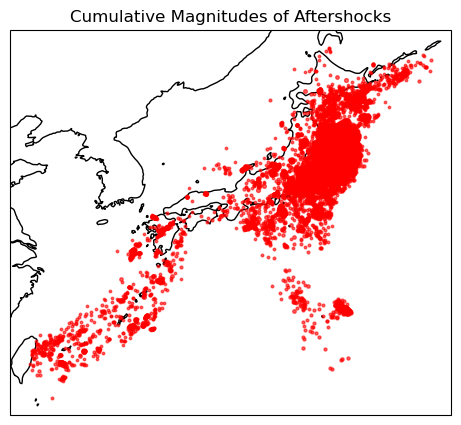

In [10]:
# Global storage for all aftershocks
global_aftershocks = []
folder_path = "Data/Plots"

# Create the folder
os.makedirs(folder_path, exist_ok=True)
def process_main_shock_data(hdf5_file_path, output_path):
    global main_shock_locations, main_shock_magnitudes, global_aftershocks
    with h5py.File(hdf5_file_path, 'r') as file:
        for id_seq in file.keys():
            main_shock_group = file[id_seq]
            aftershocks_locations = main_shock_group['aftershocks_locations'][()]
            aftershocks_magnitudes = main_shock_group['aftershocks_magnitudes'][()]

            # Append each aftershock's location and magnitude to the global list
            for location, magnitude in zip(aftershocks_locations, aftershocks_magnitudes):
                global_aftershocks.append((location, magnitude))

from collections import defaultdict
import numpy as np
import pandas as pd

def aggregate_aftershocks(grid_size_km):
    # Aggregate magnitudes by location
    location_magnitude_map = defaultdict(float)
    earth_radius_km = 6371  # Approximate radius of Earth in kilometers

    for (lat, lon), mag in global_aftershocks:
        # Convert lat, lon to a grid cell
        grid_lat = int(lat / grid_size_km * (180 / np.pi * earth_radius_km))
        grid_lon = int(lon / grid_size_km * (180 / np.pi * earth_radius_km))
        location_magnitude_map[(grid_lat, grid_lon)] += mag

    return location_magnitude_map
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_aftershocks(location_magnitude_map):
    earth_radius_km = 6371
    plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    

    # Plot each aftershock
    for (grid_lat, grid_lon), magnitude in location_magnitude_map.items():
        # Convert grid cell back to lat, lon
        lat = grid_lat * grid_size_km / (180 / np.pi * earth_radius_km)
        lon = grid_lon * grid_size_km / (180 / np.pi * earth_radius_km)
        ax.plot(lon, lat, 'ro', markersize=magnitude ** 0.5, alpha=0.6)

    ax.coastlines()

    plt.title('Cumulative Magnitudes of Aftershocks')
    picture_name = "Data/Plots/Aftershocks.png"
    plt.savefig(picture_name)
    plt.show()

process_main_shock_data(hdf5_in_put_file_path, hdf5_out_put_file_path)
location_magnitude_map = aggregate_aftershocks(grid_size_km)
plot_aftershocks(location_magnitude_map)

   name      lat       lon       begin         end
0  00NA -12.4666  130.8440  2008-03-27  2018-09-25
1  01NA -12.4782  130.9820  2008-04-08  2019-09-29
2  02NA -12.3559  130.8817  2008-09-22  2016-12-31
3  0ABI  68.3543   18.8164  2009-06-11  2024-08-17
4  0ABN  65.0337   21.3329  2023-04-05  2024-08-17


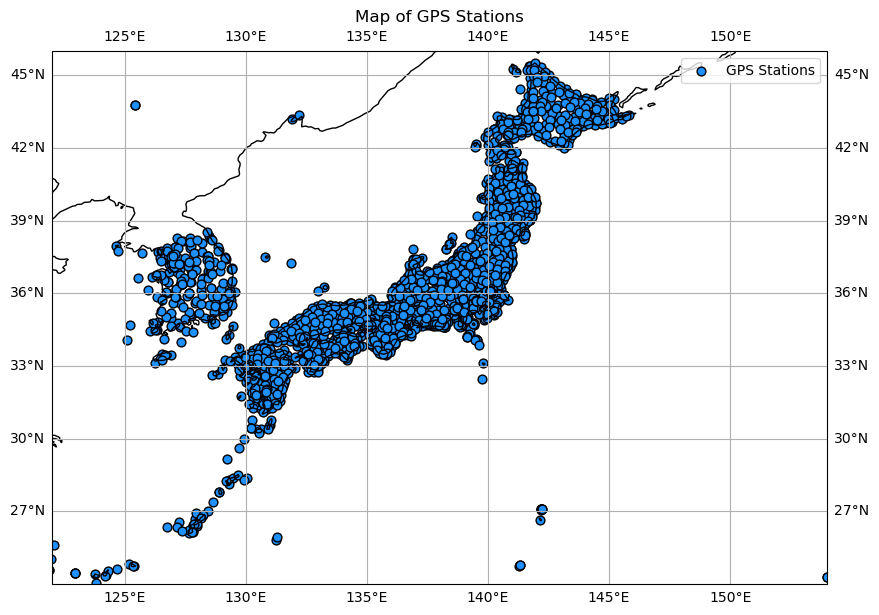

Processing main shock 103...
Processing main shock 109...


KeyboardInterrupt: 

In [12]:
## Global variables:
n_seq_init = 0  # Number of sequences processed
n_seq_discarded = 0  # Number of sequences discarded


# Add these lists to store the locations and magnitudes of the main shocks
main_shock_locations = []
main_shock_magnitudes = []

def process_main_shock_data(hdf5_file_path, output_path):
    """Process main shocks data to generate interpolated displacement maps."""
    global main_shock_locations, main_shock_magnitudes
    with h5py.File(hdf5_file_path, 'r') as file:
        for id_seq in file.keys():
            main_shock_location = file[id_seq].attrs['main_shock_location']
            main_shock_magnitude = file[id_seq].attrs['main_shock_magnitude']
            main_shock_locations.append(main_shock_location)
            main_shock_magnitudes.append(main_shock_magnitude)
            process_single_main_shock(file[id_seq], output_path, id_seq)

def plot_main_shocks(main_shock_locations = main_shock_locations, main_shock_magnitudes = main_shock_magnitudes):
    # """Plot all main shocks with varying color depending on the intensity."""
    # global main_shock_locations, main_shock_magnitudes
    # fig = plt.figure(figsize=(10, 10))
    # ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    # ax.coastlines()

    # # Convert the magnitudes to colors
    # magnitudes_norm = (main_shock_magnitudes - np.min(main_shock_magnitudes)) / (np.max(main_shock_magnitudes) - np.min(main_shock_magnitudes))
    # colors = plt.cm.viridis(magnitudes_norm)

    # # Plot the main shocks
    # for location, color in zip(main_shock_locations, colors):
    #     plt.plot(location[1], location[0], 'x', color=color, transform=ccrs.PlateCarree())

    # # Add a colorbar
    # sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=np.min(main_shock_magnitudes), vmax=np.max(main_shock_magnitudes)))
    # sm.set_array([])
    # fig.colorbar(sm, ax=ax, orientation='vertical', label='Main Shock Magnitude')

    # plt.title('Main Shocks')

    """Plot all main shocks with varying color depending on the intensity and show a bar plot of count of main shocks by magnitude intervals."""

    
    fig = plt.figure(figsize=(15, 10))  # Adjusted size to accommodate both plots

    # First subplot for the map
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
    ax1.coastlines()

    # Convert the magnitudes to colors
    magnitudes_norm = (main_shock_magnitudes - np.min(main_shock_magnitudes)) / (np.max(main_shock_magnitudes) - np.min(main_shock_magnitudes))
    colors = plt.cm.viridis(magnitudes_norm)

    # Plot the main shocks
    for location, color in zip(main_shock_locations, colors):
        ax1.plot(location[1], location[0], 'x', color=color, transform=ccrs.PlateCarree())

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=np.min(main_shock_magnitudes), vmax=np.max(main_shock_magnitudes)))
    sm.set_array([])
    fig.colorbar(sm, ax=ax1, orientation='vertical', label='Main Shock Magnitude')

    ax1.set_title('Main Shocks')

    # Second subplot for the histogram
    ax2 = fig.add_subplot(1, 2, 2)

    # Calculate the bins for magnitude intervals [x, x+0.5]
    max_mag = np.ceil(np.max(main_shock_magnitudes) + 0.5)
    min_mag = np.floor(np.min(main_shock_magnitudes))
    bins = np.arange(min_mag, max_mag, 0.5)

    # Calculate histogram
    counts, _ = np.histogram(main_shock_magnitudes, bins=bins)

    # Plot the bar chart
    ax2.bar(bins[:-1] + 0.25, counts, width=0.5, color='blue', edgecolor='black')
    ax2.set_xticks(bins + 0.25)  # Center labels on bars
    ax2.set_xticklabels([f'{bin:.1f}-{bin+0.5:.1f}' for bin in bins])
    ax2.set_xlabel('Magnitude Intervals')
    ax2.set_ylabel('Number of Main Shocks')
    ax2.set_title('Distribution of Main Shocks by Magnitude')

    plt.tight_layout()

    picture_name = "Data/Plots/Main_Shocks.png"
    plt.savefig(picture_name)
    plt.show()
    
def calculate_interpolation_grid(main_shock_location, cell_size_degs, num_cells_half):
    min_lat = main_shock_location[0] - num_cells_half * cell_size_degs
    max_lat = main_shock_location[0] + num_cells_half * cell_size_degs
    min_lon = main_shock_location[1] - num_cells_half * cell_size_degs
    max_lon = main_shock_location[1] + num_cells_half * cell_size_degs
    n_pixels_lat = 2 * num_cells_half  # Number of discretizations in the latitude direction
    n_pixels_lon = n_pixels_lat  # Number of discretizations in the longitude direction (cells)
    return min_lat, max_lat, min_lon, max_lon, n_pixels_lat, n_pixels_lon

def plot_interpolated_data_and_main_shock(interpolated_data, main_shock_location, min_lat, max_lat, min_lon, max_lon, id_seq, main_shock_date, stations_positions, gps_stations_displacements):
    # # Calculate the norm of the interpolated data
    # norm_interpolated_data = np.linalg.norm(interpolated_data, axis=2)

    # # Create a grid of latitudes and longitudes for the interpolated data
    # lats = np.linspace(min_lat, max_lat, norm_interpolated_data.shape[0])
    # lons = np.linspace(min_lon, max_lon, norm_interpolated_data.shape[1])
    # lon_grid, lat_grid = np.meshgrid(lons, lats)

    # # Create a map using Cartopy and plot the interpolated data
    # fig = plt.figure(figsize=(10, 10))
    # ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    # ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    # ax.coastlines()

   

    # # Plot the norm of the interpolated data
    # plt.pcolormesh(lon_grid, lat_grid, norm_interpolated_data, transform=ccrs.PlateCarree())
    # plt.imshow(interpolated_data, extent=(min_lon, max_lon, min_lat, max_lat), transform=ccrs.PlateCarree(), origin='lower', cmap='jet', alpha=0.5)
   
    # plt.plot(main_shock_location[1], main_shock_location[0], 'r*', markersize=15, transform=ccrs.PlateCarree())
    # plt.scatter(stations_positions[:, 1], stations_positions[:, 0], s=30, c='red', marker = 'x', transform=ccrs.PlateCarree())
    # plt.title(f'Main Shock ID: {id_seq} on {main_shock_date}')
    # plt.colorbar(label='Norm of interpolated data')
    # picture_name = f'Data/Plots/Main Shock ID: {id_seq} on {main_shock_date}'
    # plt.savefig(picture_name)
    # plt.show()


     # Create a grid of latitudes and longitudes for the interpolated data
    lats = np.linspace(min_lat, max_lat, interpolated_data.shape[0])
    lons = np.linspace(min_lon, max_lon, interpolated_data.shape[1])
    lon_grid, lat_grid = np.meshgrid(lons, lats)

    # Create a map using Cartopy and plot the vector data
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    ax.coastlines()

    # Extract components for the quiver plot
    U = interpolated_data[:, :, 0]  # x-component
    V = interpolated_data[:, :, 1]  # y-component

    # Plot the vector field using quiver
    ax.quiver(lon_grid, lat_grid, U, V, transform=ccrs.PlateCarree())

    # Plot the main shock location and station positions
    ax.plot(main_shock_location[1], main_shock_location[0], 'r*', markersize=15, transform=ccrs.PlateCarree())
    ax.scatter(stations_positions[:, 1], stations_positions[:, 0], s=30, c='red', marker='x', transform=ccrs.PlateCarree())

    # Additional plotting options
    plt.title(f'Main Shock ID: {id_seq} on {main_shock_date}')
    plt.colorbar(ax.quiver(lon_grid, lat_grid, U, V, transform=ccrs.PlateCarree()), label='Vector Magnitude')
    picture_name = f'Data/Plots/Main Shock ID: {id_seq} on {main_shock_date}.png'
    plt.savefig(picture_name)
    plt.show()

    
def process_single_main_shock(main_shock_group, output_path, id_seq):
    global n_seq_init, n_seq_discarded
    n_seq_init += 1
    print(f"Processing main shock {id_seq}...")
    gps_stations_displacements = main_shock_group['gps_stations_displacements'][()]
    # For each station, multiply the displacement by the scale factor and sum the displacements
    # over the time dimension
    ## gps_stations_displacements: (NbStations, NbDays, Displacement(X,Y,Z))
    gps_stations_displacements *= scale_factor  ## convert to mm
    gps_stations_displacements = gps_stations_displacements.reshape(-1, 3)  ## (NbStations, (X,Y,Z))
    gps_stations_positions = main_shock_group['stations_positions'][()]
    main_shock_location = main_shock_group.attrs['main_shock_location']
    after_shocks_locations = main_shock_group['aftershocks_locations'][()]
    after_shocks_locations = after_shocks_locations.reshape(-1, 2)  ## (NbAfterShocks, (X,Y))
    main_shock_day = main_shock_group.attrs['main_shock_day']
    main_shock_mag = main_shock_group.attrs['main_shock_magnitude']

    # Calculate the interpolation grid
    min_lat, max_lat, min_lon, max_lon, n_pixels_lat, n_pixels_lon = utilities.calculate_interpolation_grid(
        main_shock_location, cell_size_degs, int(num_cells / 2)
    )

  
    # labels
    labels = np.zeros((n_pixels_lat, n_pixels_lon))
    # discretize the aftershocks 
    aftershocks_rows = ((after_shocks_locations[:, 0] - min_lat) / cell_size_degs).astype('int')
    aftershocks_cols = ((after_shocks_locations[:, 1] - min_lon) / cell_size_degs).astype('int')
    # mask to make sure no event is outside the grid
    aftershocks_mask = (aftershocks_rows < n_pixels_lat) & (aftershocks_rows >= 0) & (
            aftershocks_cols < n_pixels_lon) & (
                               aftershocks_cols >= 0)
    aftershocks_rows = aftershocks_rows[aftershocks_mask]
    aftershocks_cols = aftershocks_cols[aftershocks_mask]
    # Metadata on aftershocks inside the grid for the plots
    grid_after_shocks_locations = after_shocks_locations[aftershocks_mask]
    grid_after_shocks_magnitudes = main_shock_group['aftershocks_magnitudes'][()][aftershocks_mask]
    if aftershocks_mask.sum() == 0:
        n_seq_discarded += 1
        print('Skipping:', id_seq, 'with no aftershocks inside the grid')
        return

    if not regression:
        if soft_labels:
            utilities.create_classification_soft_labels(labels, aftershocks_rows, aftershocks_cols, cell_size_rads,
                                                        sigma_softlabels * cell_size_rads)
        else:
            labels[aftershocks_rows, aftershocks_cols] = 1
    else:
        seismic_moments = 10 ** (
                1.5 * grid_after_shocks_magnitudes + 6.07)  # aftershocks magnitudes converted to their seismic moments
        if soft_labels:
            utilities.create_regression_soft_labels(labels, seismic_moments,
                                                    aftershocks_rows, aftershocks_cols, cell_size_rads,
                                                    sigma_softlabels * cell_size_rads)
        else:
            #print(aftershocks_rows)
            #print(aftershocks_cols)
            np.add.at(labels, (aftershocks_rows, aftershocks_cols),
                      seismic_moments)  # add the seismic moments to the grid (sum of seismic moments in case of multiple aftershocks in the same pixel)
            #print("Seismic moments", seismic_moments)
            #print(grid_after_shocks_magnitudes)
            #print(labels[aftershocks_rows, aftershocks_cols])
            #sys.exit()

    # The grid of interpolated displacements: channel shape (X,Y,Z, distance pixel-MS, flag to indicate if the pixel is valid or not)
    interpolated_displacements = np.zeros((n_pixels_lat, n_pixels_lon,
                                           5))
    if elasticity:
        try:
            gps_stations_displacements_means = gps_stations_displacements.mean(axis=0)
            gps_stations_displacements_stds = gps_stations_displacements.std(axis=0)
            gps_stations_displacements_standardized = (
                                                              gps_stations_displacements - gps_stations_displacements_means) / gps_stations_displacements_stds
            # gps_stations_displacements_standardized = zscore(gps_stations_displacements, axis=0) # Standardize the displacements
            automatic_reg_factor = 2  #minimal_distances[id]/cell_size_km

            utilities.elasticity_interpolation(
                interpolated_displacements,
                np.pi * main_shock_location / 180,
                np.pi * gps_stations_positions / 180,
                gps_stations_displacements_standardized,
                n_pixels_lat, n_pixels_lon,
                np.pi * min_lat / 180,
                np.pi * min_lon / 180,
                cell_size_rads,
                sigma_rads,
                min_station_pixel_distance_km,
                reg_factor=automatic_reg_factor,
                index_ratio=0.8)

            interpolated_displacements[:, :, :2] *= gps_stations_displacements_stds[:2]
            interpolated_displacements[:, :, :2] += gps_stations_displacements_means[:2]
        except Exception as e:
            raise e

    else:
        utilities.interpolate_displacements(
            interpolated_displacements,
            np.pi * main_shock_location / 180,
            np.pi * gps_stations_positions / 180,
            gps_stations_displacements,
            n_pixels_lat, n_pixels_lon,
            np.pi * min_lat / 180,
            np.pi * min_lon / 180,
            cell_size_rads,
            sigma_rads,
            min_station_pixel_distance_km,
        )
    #Save the interpolated data and labels to the output file
    save_interpolated_data(interpolated_displacements, labels, output_path, id_seq, main_shock_day, main_shock_mag,
                           main_shock_location, grid_after_shocks_locations, grid_after_shocks_magnitudes,
                           gps_stations_positions)


def save_interpolated_data(interpolated_data, labels, output_path, main_shock_id, main_shock_day, main_shock_mag,
                           main_shock_location, grid_after_shocks_locations, grid_after_shocks_magnitudes,
                           gps_stations_positions):
    with h5py.File(output_path, 'a') as f:
        if str(main_shock_id) in f:
            del f[str(main_shock_id)]
        grp = f.create_group(str(main_shock_id))
        grp.attrs['main_shock_day'] = main_shock_day
        grp.attrs['main_shock_magnitude'] = main_shock_mag
        # For the plots
        grp.attrs['main_shock_location'] = main_shock_location

        grp.create_dataset('interpolated_displacement', data=interpolated_data)
        grp.create_dataset('labels', data=labels)
        # Metadata for the plots
        grp.create_dataset('grid_after_shocks_locations', data=grid_after_shocks_locations)
        grp.create_dataset('grid_after_shocks_magnitudes', data=grid_after_shocks_magnitudes)
        grp.create_dataset('gps_station_positions', data=gps_stations_positions)




def plot_gps_stations_from_csv(csv_file_path = "Data/ngl_list.csv"):
    # Read the CSV file
    gps_data = pd.read_csv(csv_file_path, sep= " " )
    print(gps_data.head())

    # Extract coordinates
    latitudes = gps_data['lat']
    longitudes = gps_data['lon']

    # Create a map projection using Cartopy
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines()  # Draw coastlines for reference

    # Plotting GPS stations
    ax.set_extent([122, 154, 24, 46], crs=ccrs.PlateCarree())
    scatter = ax.scatter(longitudes, latitudes, color='dodgerblue', s=40, marker='o', edgecolor='black', label='GPS Stations', transform=ccrs.Geodetic())

    # Optional: Add legend and gridlines for better readability
    ax.legend(loc='upper right')
    ax.gridlines(draw_labels=True)

    plt.title('Map of GPS Stations')
    picture_name = "Data/Plots/GPS_Stations.png"
    plt.savefig(picture_name)
    plt.show()


plot_gps_stations_from_csv()
# Main
def main():
    process_main_shock_data(hdf5_in_put_file_path, hdf5_out_put_file_path)
    print(main_shock_magnitudes)
    plot_main_shocks()


if __name__ == '__main__':
    main()
    print('Number of sequences processed:', n_seq_init)
    print('Number of sequences discarded:', n_seq_discarded)
    print('Number of sequences kept:', n_seq_init - n_seq_discarded)